In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import  mean_squared_error, r2_score
from collections import Counter

import statsmodels.api as sm

In [8]:
cal = pd.read_csv('calendar.csv.gz')
listd = pd.read_csv('listings.csv.gz')
lists = pd.read_csv('listings.csv')
revs = pd.read_csv('reviews.csv.gz')
nhood = pd.read_csv('neighbourhoods.csv')
purelst = pd.read_csv('listings.csv.gz')

In [9]:
# pd.set_option('display.max_colu?mns', 96)
pd.set_option('display.max_rows', 96)

In [10]:
#CLEANUP incoming dataframes

listd_drop_cols = ['scrape_id','last_scraped','experiences_offered','thumbnail_url','medium_url','xl_picture_url',\
                   'host_name','host_location','neighbourhood_group_cleansed','square_feet',\
                   'maximum_nights','is_business_travel_ready']

# listd_numc_cols
# listd_catz_cols

print(len(listd.columns), len(listd_drop_cols))
listd.drop(listd_drop_cols,axis=1,inplace=True )
print(len(listd.columns), len(listd_drop_cols))

96 12
84 12


# ALL TRANSFORMATIONS FUNCTIONS  : 

In [11]:
print(cal.date.min(),cal.date.max())
print(revs.date.min(),revs.date.max())
# print(lists.last_review.min(),lists.last_review.max())

2018-07-05 2019-07-04
2009-05-03 2018-07-05


In [12]:
# tmp=listd.copy() # Create a new copy of the existing dataframe otherwise it is only by reference
# tmp.head().T

In [13]:
def price_xform(dframe,colname):
    dframe[colname]=dframe[colname].str.replace('$','')
    dframe[colname]=dframe[colname].str.replace(',','')
    dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [14]:
def cat_rename(dframe,colname,src,tgt):
    dframe[colname]=dframe[colname].str.replace(src,tgt)
#     dframe[colname]=dframe[colname].str.replace(',','')
#     dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [15]:
def create_dummies(dframe,colname):
#     dfnew=dframe.copy()
    dframe=pd.get_dummies(data=dframe, columns=[colname])# create dummies and drop the parent column
    dframe.drop(columns=[dframe.columns[-1]],inplace=True) #dropped the last column from the add dummies
    return dframe

In [16]:
#Impute Null Rows based on the specified column
def impute_nullrows(dframe,colname):
    print(dframe[colname].isnull().sum())
    dftmp=dframe[~dframe[colname].isnull()]   # remove nulls from one column
    print(dftmp[colname].isnull().sum())
    return dftmp


# TRANSFORM ACTIONS

In [17]:
# Convert to Booleans
listd['host_is_superhost'] = listd.apply(lambda x:  x.host_is_superhost=='t', axis= 1)
listd['host_has_profile_pic'] = listd.apply(lambda x:  x.host_has_profile_pic=='t', axis= 1)
listd['host_identity_verified'] = listd.apply(lambda x:  x.host_identity_verified=='t', axis= 1)
listd['instant_bookable'] = listd.apply(lambda x:  x.instant_bookable=='t', axis= 1)

In [18]:
#Transform all the price columns to remove "$" and ","

price_xform(listd,'price')
price_xform(listd,'weekly_price')
price_xform(listd,'monthly_price')
price_xform(listd,'security_deposit')
price_xform(listd,'cleaning_fee')
price_xform(listd,'extra_people')

In [19]:
#Transform the room_type . to create a meaningful name and create dummies

cat_rename(listd,'room_type','Entire home/apt','full')
cat_rename(listd,'room_type','Private room','pvt')
cat_rename(listd,'room_type','Shared room','shared')

listd=create_dummies(listd,'room_type')
# listd=pd.get_dummies(data=listd, columns=['room_type'])  # create dummies and drop the parent column
# listd.drop(columns=[listd.columns[-1]],inplace=True)  #dropped the last column from the add dummies

In [20]:
#Transform the bed_type . to create a meaningful name and create dummies
listd['bed_type'] = listd.apply(lambda x: x.bed_type=='Real Bed', axis=1)

In [21]:
#Put a count on amenities,   IF it does not work, pick the most important feature
listd['amentcnt'] =   listd.apply(lambda x: len(x.amenities.split(",")), axis=1)

In [22]:
#!!! APPLY the same for the test data also
#Impute the to remove the rows with no zipcode.  !!! APPLY the same for the test data also
listd=listd[~listd['zipcode'].isnull()]   # remove nulls from one column




In [23]:
#Impute the null values with meaningful data

listd['cleaning_fee']=listd['cleaning_fee'].fillna(0)
listd['review_scores_cleanliness'] = listd['review_scores_cleanliness'].fillna(listd.review_scores_cleanliness.mean())

listd['review_scores_location'] = listd['review_scores_location'].fillna(listd.review_scores_location.mean())
listd['review_scores_value'] = listd['review_scores_value'].fillna(listd.review_scores_value.mean())




In [24]:
# mask1 = listd['minimum_nights']>7 
# mask2 = listd['minimum_nights']<=32
# maskmid=mask1 & mask2 
# maskmid = (listd['minimum_nights']>7) & (listd['minimum_nights']<=32)
# mask2
# maskmid
listd.loc[listd['minimum_nights']<=7,'min_night_stay'] = 'short'
listd.loc[(listd['minimum_nights']>7) & (listd['minimum_nights']<=32),'min_night_stay'] = 'mid'
listd.loc[listd['minimum_nights']>32,'min_night_stay'] = 'long'
listd=create_dummies(listd,'min_night_stay')

In [25]:
#Condensing the property_type to sub categories

listd.loc[listd['property_type']=='Apartment', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Condominium', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guest suite', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Townhouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guesthouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Tiny house', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Timeshare', 'ppt_condensed'] = 'apt'

listd.loc[listd['property_type']=='Serviced apartment', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Bed and breakfast', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Treehouse', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Cabin', 'ppt_condensed'] = 'aptspl'

listd.loc[listd['property_type']=='Bus', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Boat', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Camper/RV', 'ppt_condensed'] = 'auto'

listd.loc[listd['property_type']=='Hostel', 'ppt_condensed'] = 'hostel'

listd.loc[listd['property_type']=='Boutique hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Resort', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Aparthotel', 'ppt_condensed'] = 'hotel'

listd.loc[listd['property_type']=='House', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Bungalow', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Cottage', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Villa', 'ppt_condensed'] = 'house'

listd.loc[listd['property_type']=='Other', 'ppt_condensed'] = 'other'

listd.loc[listd['property_type']=='Loft', 'ppt_condensed'] = 'room'

listd=create_dummies(listd,'ppt_condensed')

In [26]:
listd=create_dummies(listd,'zipcode')

In [27]:
#imputing some more missing values

listd['cleaning_fee'].fillna(0, inplace=True)
listd['beds'].fillna(0, inplace=True)
listd['bathrooms'].fillna(0, inplace=True)

In [28]:
# lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds',\
#              'bathrooms','guests_included','zipcode']

listd_drop_cols2=['id', 'listing_url', 'name', 'summary', 'space', 'description',\
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',\
       'house_rules', 'picture_url', 'host_id', 'host_url', 'host_since',\
       'host_about', 'host_response_time', 'host_response_rate',\
       'host_acceptance_rate', 'host_thumbnail_url',\
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',\
       'host_total_listings_count', 'host_verifications',\
       'host_has_profile_pic', 'street',\
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',\
       'market', 'smart_location', 'country_code', 'country', 'latitude',\
       'longitude', 'is_location_exact', 'property_type',\
       'amenities',\
       'weekly_price', 'monthly_price', 'security_deposit',\
       'extra_people', 'minimum_nights', 'calendar_updated',\
       'has_availability', 'availability_30', 'availability_60',\
       'availability_90', 'availability_365', 'calendar_last_scraped',\
       'number_of_reviews', 'first_review', 'last_review',\
       'review_scores_rating', 'review_scores_accuracy',\
       'review_scores_cleanliness', 'review_scores_checkin',\
       'review_scores_communication', 'review_scores_location',\
       'review_scores_value', 'requires_license', 'license',\
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',\
       'require_guest_profile_picture', 'require_guest_phone_verification',\
       'calculated_host_listings_count', 'reviews_per_month']
# listd_drop_cols2=['property_type','minimum_nights']
listd.drop(listd_drop_cols2,axis=1,inplace=True )

In [29]:
listd.columns

Index(['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
       'guests_included', 'room_type_full', 'room_type_pvt', 'amentcnt',
       'min_night_stay_long', 'min_night_stay_mid', 'ppt_condensed_apt',
       'ppt_condensed_aptspl', 'ppt_condensed_auto', 'ppt_condensed_hostel',
       'ppt_condensed_hotel', 'ppt_condensed_house', 'ppt_condensed_other',
       'zipcode_94014.0', 'zipcode_94015.0', 'zipcode_94102.0',
       'zipcode_94103.0', 'zipcode_94104.0', 'zipcode_94105.0',
       'zipcode_94107.0', 'zipcode_94108.0', 'zipcode_94109.0',
       'zipcode_94110.0', 'zipcode_94111.0', 'zipcode_94112.0',
       'zipcode_94114.0', 'zipcode_94115.0', 'zipcode_94116.0',
       'zipcode_94117.0', 'zipcode_94118.0', 'zipcode_94121.0',
       'zipcode_94122.0', 'zipcode_94123.0', 'zipcode_94124.0',
       'zipcode_94127.0', 'zipcode_94129.0', 'zipcode_94131.0',
       'zipcode_94132.0', 'zipcode_94133.0

In [30]:
listd.shape

(4669, 50)

# EXTRA BEGIN

# EXTRA END

In [31]:
dfcorr=listd.corr()
# dfcorr.price.sort_values()


In [32]:
dfcorr.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,guests_included,...,zipcode_94122.0,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94129.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0
host_is_superhost,1.000000,0.175279,-0.066246,-0.073244,-0.068472,-0.093756,-0.021697,-0.013003,-0.035032,0.004400,...,0.047449,-0.008327,-0.000980,0.016222,-0.012798,0.017896,-0.016272,-0.024038,-0.011413,-0.018776
host_identity_verified,0.175279,1.000000,0.022881,0.037757,0.083777,0.009490,-0.020877,0.057496,0.062758,0.043328,...,-0.004123,-0.026080,0.009686,0.000057,0.010770,0.014712,-0.018414,-0.054392,-0.035066,-0.024679
accommodates,-0.066246,0.022881,1.000000,0.480117,0.769191,0.834543,0.071087,0.434465,0.549483,0.559105,...,0.009334,0.023442,-0.009602,0.008477,0.019520,0.012934,-0.023730,0.001014,0.027702,0.004085
bathrooms,-0.073244,0.037757,0.480117,1.000000,0.554560,0.493639,0.036346,0.334613,0.376771,0.285099,...,-0.020438,0.037669,-0.014356,0.025868,-0.006674,0.002485,0.021276,-0.040516,-0.012096,0.003848
bedrooms,-0.068472,0.083777,0.769191,0.554560,1.000000,0.730330,0.046203,0.434527,0.581186,0.520352,...,-0.003992,0.037804,-0.023596,0.021624,0.009492,0.034685,-0.015172,0.012337,0.007095,0.001438


In [33]:
dfcorr.price.sort_values()

room_type_pvt            -0.255959
zipcode_94112.0          -0.081166
ppt_condensed_hostel     -0.065111
zipcode_94124.0          -0.058205
zipcode_94122.0          -0.046702
zipcode_94132.0          -0.043868
zipcode_94102.0          -0.043633
zipcode_94134.0          -0.037803
min_night_stay_mid       -0.037199
zipcode_94111.0          -0.027050
ppt_condensed_hotel      -0.026284
zipcode_94110.0          -0.025305
ppt_condensed_apt        -0.024605
zipcode_94014.0          -0.022688
ppt_condensed_aptspl     -0.020042
zipcode_94127.0          -0.018272
zipcode_94116.0          -0.015017
ppt_condensed_auto       -0.014007
ppt_condensed_other      -0.013178
host_is_superhost        -0.013003
zipcode_94015.0          -0.009239
zipcode_94107.0           0.001773
zipcode_94108.0           0.002104
zipcode_94118.0           0.002555
zipcode_94105.0           0.002993
zipcode_94131.0           0.003971
zipcode_94129.0           0.004267
zipcode_94158.0           0.006018
zipcode_94103.0     

'''
lreg_cols_master = ['square_feet','weekly_price','cleaning_fee','accommodates','bedrooms','beds','bathrooms','guests_included','zipcode']
lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds','bathrooms','guests_included','zipcode']
'''

In [34]:
dflreg = listd.copy()
dflreg = sm.add_constant(dflreg)

In [35]:
dflreg['host_is_superhost'] = (dflreg['host_is_superhost'] == True).astype(int)
dflreg['host_identity_verified'] = (dflreg['host_identity_verified'] == True).astype(int)
dflreg['bed_type'] = (dflreg['bed_type'] == True).astype(int)

In [36]:
dfscatter=dflreg.loc[:,'price':'guests_included']
dfscatter.head()

,price,cleaning_fee,guests_included
0,170.0,100.0,2
1,235.0,100.0,2
2,65.0,50.0,1
3,63.0,30.0,1
4,65.0,50.0,1


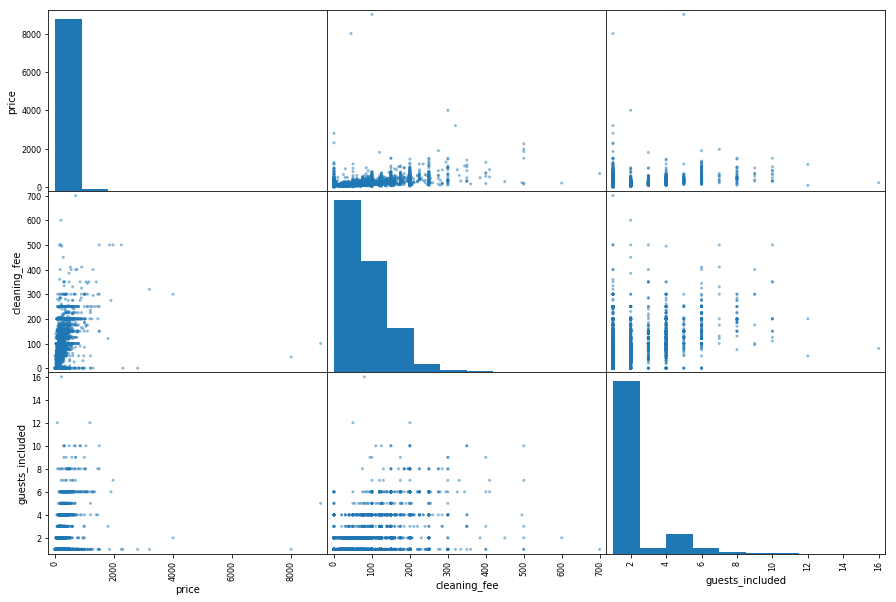

In [37]:
pd.plotting.scatter_matrix(dfscatter,figsize=(15,10));

In [38]:
listd_insig_cols = ['host_is_superhost','host_identity_verified','bed_type','guests_included','room_type_full',\
                    'room_type_pvt','amentcnt','ppt_condensed_apt','ppt_condensed_aptspl','ppt_condensed_auto',\
                    'ppt_condensed_hotel','ppt_condensed_other',\
                    'zipcode_94014.0', 'zipcode_94015.0', 'zipcode_94102.0',\
                    'zipcode_94103.0', 'zipcode_94104.0', 'zipcode_94105.0',\
                    'zipcode_94107.0', 'zipcode_94108.0', 'zipcode_94109.0',\
                    'zipcode_94110.0', 'zipcode_94111.0', 'zipcode_94112.0',\
                    'zipcode_94114.0', 'zipcode_94115.0', 'zipcode_94116.0',\
                    'zipcode_94117.0', 'zipcode_94118.0', 'zipcode_94121.0',\
                    'zipcode_94122.0', 'zipcode_94123.0', 'zipcode_94124.0',\
                    'zipcode_94127.0', 'zipcode_94129.0', 'zipcode_94131.0',\
                    'zipcode_94132.0', 'zipcode_94133.0', 'zipcode_94134.0','zipcode_94158.0']
# dflreg.head().T

In [39]:
dfscat=dflreg.copy()
dflreg.drop(listd_insig_cols,axis=1,inplace=True)
y=dflreg.price
X=dflreg.drop(['price'],axis=1)

In [40]:
# X=dflreg.drop([listd_insig_cols],axis=1)
# listd.drop(listd_drop_cols,axis=1,inplace=True )

In [41]:
X_chunk, X_test, y_chunk, y_test = train_test_split(X, y, test_size=0.20, random_state=47)
X_train, X_vald, y_train, y_vald = train_test_split(X_chunk, y_chunk, test_size=0.20, random_state=47)

In [42]:
X_train = X_chunk.copy()
y_train = y_chunk.copy()

In [43]:
print(X_train.shape, X_vald.shape, X_test.shape)
print(y_train.shape, y_vald.shape, y_test.shape)

(3735, 10) (747, 10) (934, 10)
(3735,) (747,) (934,)


In [1]:
# -------------------------------------------------------

In [45]:
class TreeNode(object):
    '''
    A node class for a decision tree.
    '''
    def __init__(self):
        self.column = None  # (int)    index of feature to split on
        self.value = None  # value of the feature to split on
        self.categorical = True  # (bool) whether or not node is split on
                                 # categorial feature
        self.name = None    # (string) name of feature (or name of class in the
                            #          case of a list)
        self.left = None    # (TreeNode) left child
        self.right = None   # (TreeNode) right child
        self.leaf = False   # (bool)   true if node is a leaf, false otherwise
        self.classes = Counter()  # (Counter) only necessary for leaf node:
                                  #           key is class name and value is
                                  #           count of the count of data points
                                  #           that terminate at this leaf

    def predict_one(self, x):
        '''
        INPUT:
            - x: 1d numpy array (single data point)
        OUTPUT:
            - y: predicted label
        Return the predicted label for a single data point.
        '''
        if self.leaf:
            return self.name
        col_value = x[self.column]

        if self.categorical:
            if col_value == self.value:
                return self.left.predict_one(x)
            else:
                return self.right.predict_one(x)
        else:
            if col_value < self.value:
                return self.left.predict_one(x)
            else:
                return self.right.predict_one(x)

    # This is for visualizing your tree. You don't need to look into this code.
    def as_string(self, level=0, prefix=""):
        '''
        INPUT:
            - level: int (amount to indent)
        OUTPUT:
            - prefix: str (to start the line with)
        Return a string representation of the tree rooted at this node.
        '''
        result = ""
        if prefix:
            indent = "  |   " * (level - 1) + "  |-> "
            result += indent + prefix + "\n"
        indent = "  |   " * level
        result += indent + "  " + str(self.name) + "\n"
        if not self.leaf:
            if self.categorical:
                left_key = str(self.value)
                right_key = "no " + str(self.value)
            else:
                left_key = "< " + str(self.value)
                right_key = ">= " + str(self.value)
            result += self.left.as_string(level + 1, left_key + ":")
            result += self.right.as_string(level + 1, right_key + ":")
        return result

    def __repr__(self):
        return self.as_string().strip()

In [47]:
# from TreeNode import TreeNode


class DecisionTree(object):
    '''
    A decision tree class.
    '''

    def __init__(self, impurity_criterion='entropy', num_features=None):
        '''
        Initialize an empty DecisionTree.
        '''

        self.root = None  # root Node
        self.feature_names = None  # string names of features (for interpreting
                                   # the tree)
        self.categorical = None  # Boolean array of whether variable is
                                 # categorical (or continuous)
        self.impurity_criterion = self._entropy \
                                  if impurity_criterion == 'entropy' \
                                  else self._gini
        self.num_features = num_features

    def fit(self, X, y, feature_names=None):
        '''
        INPUT:
            - X: 2d numpy array
            - y: 1d numpy array
            - feature_names: numpy array of strings
        OUTPUT: None
        Build the decision tree.
        X is a 2 dimensional array with each column being a feature and each
        row a data point.
        y is a 1 dimensional array with each value being the corresponding
        label.
        feature_names is an optional list containing the names of each of the
        features.
        '''

        if feature_names is None or len(feature_names) != X.shape[1]:
            self.feature_names = np.arange(X.shape[1])
        else:
            self.feature_names = feature_names

        # Create True/False array of whether the variable is categorical
        is_categorical = lambda x: isinstance(x, str) or \
                                   isinstance(x, bool)
        self.categorical = np.vectorize(is_categorical)(X[0])

        self.root = self._build_tree(X, y)
        if not self.num_features:
            self.num_features = X.shape[1]

    def _build_tree(self, X, y):
        '''
        INPUT:
            - X: 2d numpy array
            - y: 1d numpy array
        OUTPUT:
            - TreeNode
        Recursively build the decision tree. Return the root node.
        '''

        node = TreeNode()
        index, value, splits = self._choose_split_index(X, y)

        if index is None or len(np.unique(y)) == 1:
            node.leaf = True
            node.classes = Counter(y)
            node.name = node.classes.most_common(1)[0][0]
        else:
            X1, y1, X2, y2 = splits
            node.column = index
            node.name = self.feature_names[index]
            node.value = value
            node.categorical = self.categorical[index]
            node.left = self._build_tree(X1, y1)
            node.right = self._build_tree(X2, y2)
        return node

    def _entropy(self, y):
        '''
        INPUT:
            - y: 1d numpy array
        OUTPUT:
            - float
        Return the entropy of the array y.
        '''
        n = y.shape[0]
        summation = 0
        for c_i in np.unique(y):
            prob = np.mean(y == c_i)
            summation += prob * np.log2(prob)
        return -summation

    def _gini(self, y):
        '''
        INPUT:
            - y: 1d numpy array
        OUTPUT:
            - float
        Return the gini impurity of the array y.
        '''
        n = y.shape[0]
        summation = 0
        for c_i in np.unique(y):
            prob = np.mean(y == c_i)
            summation += prob**2
        return 1 - summation

    def _make_split(self, X, y, split_index, split_value):
        '''
        INPUT:
            - X: 2d numpy array
            - y: 1d numpy array
            - split_index: int (index of feature)
            - split_value: int/float/bool/str (value of feature)
        OUTPUT:
            - X1: 2d numpy array (feature matrix for subset 1)
            - y1: 1d numpy array (labels for subset 1)
            - X2: 2d numpy array (feature matrix for subset 2)
            - y2: 1d numpy array (labels for subset 2)
        Return the two subsets of the dataset achieved by the given feature and
        value to split on.
        Call the method like this:
        >>> X1, y1, X2, y2 = self._make_split(X, y, split_index, split_value)
        X1, y1 is a subset of the data.
        X2, y2 is the other subset of the data.
        '''
        split_col = X[:, split_index]
        if self.categorical[split_index]:
            idx = (split_col == split_value)
        else:
            idx = (split_col < split_value)
        return X[idx], y[idx], X[~idx], y[~idx]

    def _information_gain(self, y, y1, y2):
        '''
        INPUT:
            - y: 1d numpy array
            - y1: 1d numpy array (labels for subset 1)
            - y2: 1d numpy array (labels for subset 2)
        OUTPUT:
            - float
        Return the information gain of making the given split.
        Use self.impurity_criterion(y) rather than calling _entropy or _gini
        directly.
        '''
        n = y.shape[0]
        weighted_child_imp = 0
        for y_i in (y1, y2):
            weighted_child_imp += self.impurity_criterion(y_i) * y_i.shape[0] / n
        return self.impurity_criterion(y) - weighted_child_imp

    def _choose_split_index(self, X, y):
        '''
        INPUT:
            - X: 2d numpy array
            - y: 1d numpy array
        OUTPUT:
            - index: int (index of feature)
            - value: int/float/bool/str (value of feature)
            - splits: (2d array, 1d array, 2d array, 1d array)
        Determine which feature and value to split on. Return the index and
        value of the optimal split along with the split of the dataset.
        Return None, None, None if there is no split which improves information
        gain.
        Call the method like this:
        >>> index, value, splits = self._choose_split_index(X, y)
        >>> X1, y1, X2, y2 = splits
        '''

        split_index, split_value, splits = None, None, None
        feature_indices = np.random.choice(X.shape[1], self.num_features, replace=False)
        max_gain = 0
        X_sub = X[:, feature_indices]

        for i in range(X_sub.shape[1]):
            values = np.unique(X_sub[:, i])
            if len(values) < 2:
                continue
            for val in values:
                temp_splits = self._make_split(X_sub, y, i, val)
                X1, y1, X2, y2 = temp_splits
                gain = self._information_gain(y, y1, y2)
                if gain > max_gain:
                    max_gain = gain
                    split_index, split_value = i, val
                    splits = temp_splits
        return split_index, split_value, splits

    def predict(self, X):
        '''
        INPUT:
            - X: 2d numpy array
        OUTPUT:
            - y: 1d numpy array
        Return an array of predictions for the feature matrix X.
        '''
        return np.array([self.root.predict_one(row) for row in X])
        
    def __str__(self):
        '''
        Return string representation of the Decision Tree.
        '''
        return str(self.root)

In [48]:
class RandomForest(object):
    '''A Random Forest class'''

    def __init__(self, num_trees, num_features):
        '''
           num_trees:  number of trees to create in the forest:
        num_features:  the number of features to consider when choosing the
                           best split for each node of the decision trees
        '''
        self.num_trees = num_trees
        self.num_features = num_features
        self.forest = None

    def fit(self, X, y):
        '''
        X:  two dimensional numpy array representing feature matrix
                for test data
        y:  numpy array representing labels for test data
        '''
        self.forest = self.build_forest(X, y, self.num_trees, X.shape[0], \
                                        self.num_features)

    def build_forest(self, X, y, num_trees, num_samples, num_features):
        '''
        Return a list of num_trees DecisionTrees.
        '''
        forest = []
        for i in range(num_trees):
            sample_indices = np.random.choice(X.shape[0], num_samples, \
                                              replace=True)
            sample_X = np.array(X[sample_indices])
            sample_y = np.array(y[sample_indices])
            dt = DecisionTree(num_features=self.num_features)
            dt.fit(sample_X, sample_y)
            forest.append(dt)
        return forest

    def predict(self, X):
        '''
        Return a numpy array of the labels predicted for the given test data.
        '''
        answers = np.array([tree.predict(X) for tree in self.forest]).T
        return np.array([Counter(row).most_common(1)[0][0] for row in answers])

    def score(self, X, y):
        '''
        Return the accuracy of the Random Forest for the given test data and
        labels.
        '''
        return (self.predict(X) == y).mean()

In [49]:
#     df = pd.read_csv('./data/congressional_voting.csv', names=['Party']+list(range(1, 17)))
y = listd.pop('price').values
X = listd.values
X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForest(num_trees=10, num_features=10)
rf.fit(X_train, y_train)
print("Random Forest score:", rf.score(X_test, y_test))

Random Forest score: 0.0136986301369863


In [ ]:
y = listd.pop('price').values
X = listd.values
X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForest(num_trees=10, num_features=10)
rf.fit(X_train, y_train)
print("Random Forest score:", rf.score(X_test, y_test))